## Exploring COVID-19 Data through Modeling

We will investigate COVID-19 data over the past year. This data contains information about COVID-19 case counts, mortalities, vaccination rates, and various other metadata that can assist in modeling various aspects of COVID-19.

We will demonstrate:
* Data cleaning and EDA using Pandas
* Modeling
* Visualization

In [1]:
import numpy as np
from geopy import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import *
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import re

cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
vaccinations = pd.read_csv('data/people_vaccinated_us_timeline.csv') # https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv
counties = pd.read_csv('data/co-est2020.csv', encoding='latin-1') # https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv
mask_use = pd.read_csv('data/mask-use-by-county.csv') # https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv



## Data Cleaning

Impute the null values in *all* the datasets with zero values or empty strings where appropriate.

In [2]:
cases = cases.fillna(0)
vaccinations = vaccinations.fillna(0)

In [3]:
print(counties.info())
counties

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3194 entries, 0 to 3193
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   SUMLEV             3194 non-null   int64 
 1   REGION             3194 non-null   int64 
 2   DIVISION           3194 non-null   int64 
 3   STATE              3194 non-null   int64 
 4   COUNTY             3194 non-null   int64 
 5   STNAME             3194 non-null   object
 6   CTYNAME            3194 non-null   object
 7   CENSUS2010POP      3194 non-null   object
 8   ESTIMATESBASE2010  3194 non-null   int64 
 9   POPESTIMATE2010    3194 non-null   int64 
 10  POPESTIMATE2011    3194 non-null   int64 
 11  POPESTIMATE2012    3194 non-null   int64 
 12  POPESTIMATE2013    3194 non-null   int64 
 13  POPESTIMATE2014    3194 non-null   int64 
 14  POPESTIMATE2015    3194 non-null   int64 
 15  POPESTIMATE2016    3194 non-null   int64 
 16  POPESTIMATE2017    3194 non-null   int64 


,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE042020,POPESTIMATE2020
0,40,3,6,1,0,Alabama,Alabama,4779736,4780118,4785514,...,4816632,4831586,4843737,4854803,4866824,4877989,4891628,4907965,4920706,4921532
1,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,54970,54747,54922,54903,55302,55448,55533,55769,56130,56145
2,50,3,6,1,3,Alabama,Baldwin County,182265,182263,183121,...,190203,194978,199306,203101,207787,212737,218071,223565,227989,229287
3,50,3,6,1,5,Alabama,Barbour County,27457,27454,27325,...,27172,26946,26768,26300,25828,25169,24887,24657,24652,24589
4,50,3,6,1,7,Alabama,Bibb County,22915,22904,22858,...,22657,22510,22541,22553,22590,22532,22300,22313,22199,22136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3189,50,4,8,56,37,Wyoming,Sweetwater County,43806,43806,43580,...,45032,45189,44996,44780,44319,43663,43188,42917,42717,42673
3190,50,4,8,56,39,Wyoming,Teton County,21294,21298,21298,...,21643,22335,22801,23083,23255,23383,23261,23385,23453,23497
3191,50,4,8,56,41,Wyoming,Uinta County,21118,21121,21090,...,21008,20969,20835,20777,20711,20449,20299,20196,20169,20215
3192,50,4,8,56,43,Wyoming,Washakie County,8533,8528,8531,...,8410,8417,8277,8282,8180,8013,7886,7824,7756,7760


In [4]:
print(cases.info())
cases

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3342 entries, 0 to 3341
Columns: 611 entries, UID to 9/12/21
dtypes: float64(3), int64(602), object(6)
memory usage: 15.6+ MB
None


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,9/3/21,9/4/21,9/5/21,9/6/21,9/7/21,9/8/21,9/9/21,9/10/21,9/11/21,9/12/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,8909,8959,9012,9048,9063,9108,9145,9207,9246,9287
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,33789,33968,34063,34142,34246,34393,34536,34726,34872,34950
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,3142,3166,3184,3197,3207,3225,3243,3260,3282,3295
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,3580,3618,3628,3641,3661,3694,3727,3752,3778,3795
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,8763,8830,8862,8899,8951,8998,9048,9095,9161,9176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,...,4502,4502,4502,4502,4568,4572,4587,4611,4611,4611
3338,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,...,3053,3053,3053,3053,3086,3141,3168,3204,3204,3204
3339,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3340,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,...,1080,1080,1080,1080,1087,1104,1111,1120,1120,1120


In [5]:
print(mask_use.info())
mask_use

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   COUNTYFP    3142 non-null   int64  
 1   NEVER       3142 non-null   float64
 2   RARELY      3142 non-null   float64
 3   SOMETIMES   3142 non-null   float64
 4   FREQUENTLY  3142 non-null   float64
 5   ALWAYS      3142 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 147.4 KB
None


,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459
...,...,...,...,...,...,...
3137,56037,0.061,0.295,0.230,0.146,0.268
3138,56039,0.095,0.157,0.160,0.247,0.340
3139,56041,0.098,0.278,0.154,0.207,0.264
3140,56043,0.204,0.155,0.069,0.285,0.287


Generate a valid FIPS code for the counties table.

In [6]:
"""
State-level FIPS codes have two digits, county-level FIPS codes have five digits of which the 
first two are the FIPS code of the state to which the county belongs.
"""

str_state_num=counties[['STATE']].astype(str)
zero_extend_str_state = ['0'+x if len(x)==1 else x for x in str_state_num['STATE']]
str_county_num=counties[['COUNTY']].astype(str)
zero_extend_str_county = ['00'+x if len(x)==1 else '0'+x if len(x)==2 else x for x in str_county_num['COUNTY']]
str_state_num['STATE'] = zero_extend_str_state
str_county_num['COUNTY'] = zero_extend_str_county
FIPS =  str_state_num['STATE'] + str_county_num['COUNTY']
counties['FIPS'] = FIPS
counties


,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE042020,POPESTIMATE2020,FIPS
0,40,3,6,1,0,Alabama,Alabama,4779736,4780118,4785514,...,4831586,4843737,4854803,4866824,4877989,4891628,4907965,4920706,4921532,01000
1,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,54747,54922,54903,55302,55448,55533,55769,56130,56145,01001
2,50,3,6,1,3,Alabama,Baldwin County,182265,182263,183121,...,194978,199306,203101,207787,212737,218071,223565,227989,229287,01003
3,50,3,6,1,5,Alabama,Barbour County,27457,27454,27325,...,26946,26768,26300,25828,25169,24887,24657,24652,24589,01005
4,50,3,6,1,7,Alabama,Bibb County,22915,22904,22858,...,22510,22541,22553,22590,22532,22300,22313,22199,22136,01007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3189,50,4,8,56,37,Wyoming,Sweetwater County,43806,43806,43580,...,45189,44996,44780,44319,43663,43188,42917,42717,42673,56037
3190,50,4,8,56,39,Wyoming,Teton County,21294,21298,21298,...,22335,22801,23083,23255,23383,23261,23385,23453,23497,56039
3191,50,4,8,56,41,Wyoming,Uinta County,21118,21121,21090,...,20969,20835,20777,20711,20449,20299,20196,20169,20215,56041
3192,50,4,8,56,43,Wyoming,Washakie County,8533,8528,8531,...,8417,8277,8282,8180,8013,7886,7824,7756,7760,56043


Merge the counties, cases, and mask_use tables on an appropriate primary key to generate county-wise data.

In [7]:
cases['FIPS'] = cases['FIPS'].astype(int)
cases['FIPS'] = cases['FIPS'].astype(str)
mask_use['COUNTYFP'] = mask_use['COUNTYFP'].astype(str)

zero_extend_cases = ['0'+x if len(x)==4 else x for x in cases['FIPS']]
zero_extend_mask_use = ['0'+x if len(x)==4 else x for x in mask_use['COUNTYFP']]
cases['FIPS'] = zero_extend_cases
mask_use['COUNTYFP'] = zero_extend_mask_use

county_data = counties.merge(cases, on='FIPS').merge(mask_use, left_on='FIPS',right_on='COUNTYFP')
county_data

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,9/9/21,9/10/21,9/11/21,9/12/21,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,9145,9207,9246,9287,01001,0.053,0.074,0.134,0.295,0.444
1,50,3,6,1,3,Alabama,Baldwin County,182265,182263,183121,...,34536,34726,34872,34950,01003,0.083,0.059,0.098,0.323,0.436
2,50,3,6,1,5,Alabama,Barbour County,27457,27454,27325,...,3243,3260,3282,3295,01005,0.067,0.121,0.120,0.201,0.491
3,50,3,6,1,7,Alabama,Bibb County,22915,22904,22858,...,3727,3752,3778,3795,01007,0.020,0.034,0.096,0.278,0.572
4,50,3,6,1,9,Alabama,Blount County,57322,57322,57372,...,9048,9095,9161,9176,01009,0.053,0.114,0.180,0.194,0.459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,50,4,8,56,37,Wyoming,Sweetwater County,43806,43806,43580,...,6034,6111,6111,6111,56037,0.061,0.295,0.230,0.146,0.268
3137,50,4,8,56,39,Wyoming,Teton County,21294,21298,21298,...,4587,4611,4611,4611,56039,0.095,0.157,0.160,0.247,0.340
3138,50,4,8,56,41,Wyoming,Uinta County,21118,21121,21090,...,3168,3204,3204,3204,56041,0.098,0.278,0.154,0.207,0.264
3139,50,4,8,56,43,Wyoming,Washakie County,8533,8528,8531,...,1111,1120,1120,1120,56043,0.204,0.155,0.069,0.285,0.287


## Guided Supervised Modeling

We will be creating a supervised learning framework that will predict the number of COVID-19 cases per capita given various COVID-19 safety protocols that have been implemented. Then, we will investigate the bias, variance, and observational noise of this framework.

We will use county-wise mask usage data to predict the number of COVID-19 cases on September 12th, 2021. Create a visualization that shows the pairwise correlation between each combination of column in the mask usage data and the number of COVID-19 cases.

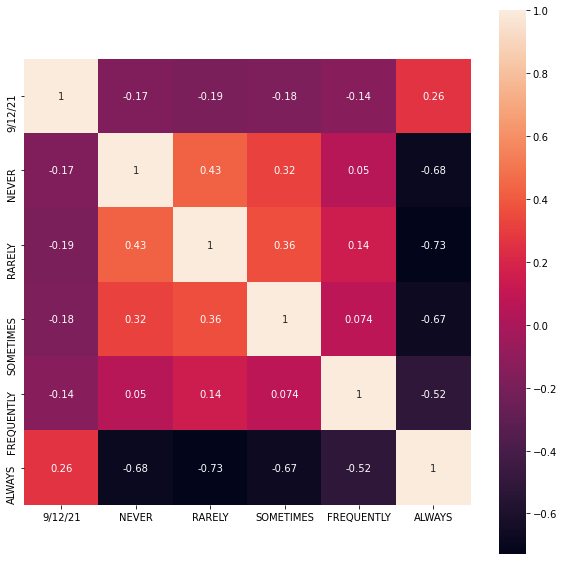

In [8]:
#Use a heatmap
plt.rcParams['figure.figsize'] = (10, 10)
plot1 = county_data[['9/12/21', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
corr = plot1.corr()
sns.heatmap(corr, square=True, annot=True);

Training a linear regression model to predict the number of COVID-19 cases using county-wise mask usage data for September 12, 2021.

In [9]:
county_data[['STNAME', 'CTYNAME', '9/12/21', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]

,STNAME,CTYNAME,9/12/21,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,Alabama,Autauga County,9287,0.053,0.074,0.134,0.295,0.444
1,Alabama,Baldwin County,34950,0.083,0.059,0.098,0.323,0.436
2,Alabama,Barbour County,3295,0.067,0.121,0.120,0.201,0.491
3,Alabama,Bibb County,3795,0.020,0.034,0.096,0.278,0.572
4,Alabama,Blount County,9176,0.053,0.114,0.180,0.194,0.459
...,...,...,...,...,...,...,...,...
3136,Wyoming,Sweetwater County,6111,0.061,0.295,0.230,0.146,0.268
3137,Wyoming,Teton County,4611,0.095,0.157,0.160,0.247,0.340
3138,Wyoming,Uinta County,3204,0.098,0.278,0.154,0.207,0.264
3139,Wyoming,Washakie County,1120,0.204,0.155,0.069,0.285,0.287


In [10]:
def RMSE(true_y_values, pred_y_values):
    return np.sqrt(np.mean((true_y_values - pred_y_values)**2))

In [11]:
X_p1 = county_data[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
y_p1 = county_data['9/12/21']

# Make sure to set random_state = 42 and test_size = 0.33!
X_p1_train, X_p1_test, y_p1_train, y_p1_test = train_test_split(X_p1, y_p1, test_size=0.33, random_state = 42)

model = LinearRegression()
model.fit(X_p1_train, y_p1_train)

train_rmse_cases = RMSE(y_p1_train, model.predict(X_p1_train))

test_rmse_cases = RMSE(y_p1_test, model.predict(X_p1_test))

train_rmse_cases, test_rmse_cases

(27834.430707426953, 62591.13087482176)

Instead of predicting the number of COVID-19 cases, we are going to predict the number of COVID-19 cases per capita.

In [12]:
X_p2 = county_data[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]

per_capita_col = county_data['9/12/21']/county_data['POPESTIMATE2020']
county_data['sept 12 cases per capita'] = per_capita_col
y_p2 = county_data['sept 12 cases per capita']

X_p2_train, X_p2_test, y_p2_train, y_p2_test = train_test_split(X_p2, y_p2, test_size=0.33, random_state = 42)

model2 = LinearRegression()
model2.fit(X_p2_train, y_p2_train)

train_rmse_cpc = RMSE(y_p2_train, model2.predict(X_p2_train))
test_rmse_cpc = RMSE(y_p2_test, model2.predict(X_p2_test))

train_rmse_cpc, test_rmse_cpc

(0.03540985737823185, 0.03816790349891605)

Visualizing the model outputs from before by plotting the predictions $\hat{y}$ versus the observations $y$.

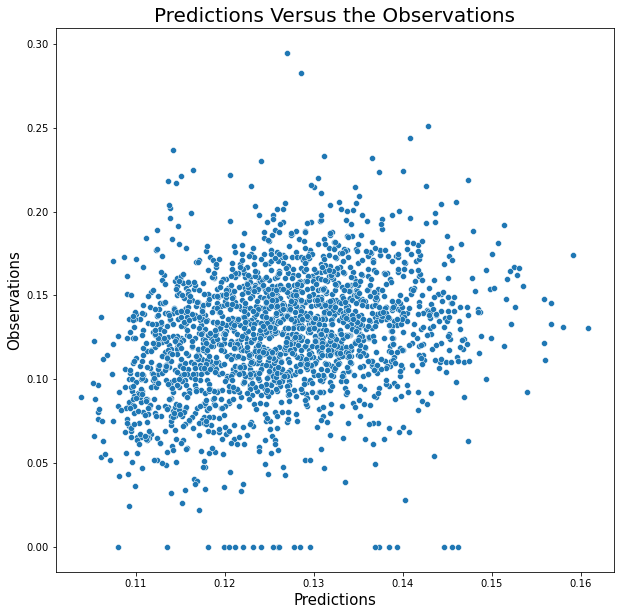

In [13]:
plotp3DataFrame = pd.DataFrame({'pred':model2.predict(X_p2_train), 'obs':y_p2_train})

#Removing some outliers
plotp3DataFrame = plotp3DataFrame[plotp3DataFrame['obs']<0.3]

plotp3X = plotp3DataFrame['pred']
plotp3Y = plotp3DataFrame['obs']
plt.rcParams['figure.figsize'] = (10, 10)
plt.title('Predictions Versus the Observations', fontsize = 20)
plt.xlabel('Predictions', fontsize = 15)
plt.ylabel('Observations', fontsize = 15)
sns.scatterplot(x=plotp3X, y=plotp3Y);

# This plot indicates there is some correlation between observations and predictions.

## Part 2

### The hypothesis we will be testing now is whether the majority of variation in unemployment numbers across counties can be explained by the number of cases across counties as well as masking rates across counties.

A: Unemploment numbers in counties during covid

B: Unemploment numbers in counties before covid

Null: The distribution in Unemployment numbers in counties are the same during and before covid

Alternative: In the counties, the unemployment numbers during covid were more, on average, than the unemployment numbers before covid

## But first lets check the relationship between covid cases and unemployment numbers in counties

In [14]:
# uploading unemployment data
# data can be found under 'county data' in: https://www.bls.gov/lau/

unemployment_rate = pd.read_csv('data/copy-of-laucntycur14.csv', dtype = {'state code':'str', 'county code':'str'}) 
unemployment_rate['FIPS'] = unemployment_rate['state code'] + unemployment_rate['county code']
unemployment_rate = unemployment_rate[['County Name/State Abbreviation', 'Period', 'Force', 'Employed', 'Unemployed', '(%)', 'FIPS']]
unemployment_rate


,County Name/State Abbreviation,Period,Force,Employed,Unemployed,(%),FIPS
0,"Autauga County, AL",Sep-20,"25,525","24,133","1,392",5.5,01001
1,"Baldwin County, AL",Sep-20,"95,737","90,075","5,662",5.9,01003
2,"Barbour County, AL",Sep-20,"8,577","7,710",867,10.1,01005
3,"Bibb County, AL",Sep-20,"8,500","7,901",599,7.0,01007
4,"Blount County, AL",Sep-20,"24,237","23,194","1,043",4.3,01009
...,...,...,...,...,...,...,...
45064,"Yabucoa Municipio, PR",Oct-21 p,"8,406","7,676",730,8.7,72151
45065,"Yauco Municipio, PR",Oct-21 p,"9,507","8,492","1,015",10.7,72153
45066,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45067,NaN,NaN,NaN,NaN,NaN,"SOURCE: BLS, LAUS",NaN


In [15]:
# Cross Validation Functions

from sklearn.model_selection import KFold
def rmse(actual_y, predicted_y):
    return np.sqrt(np.mean((actual_y - predicted_y)**2))
def compute_CV_error(model, X_train, Y_train):
    kf = KFold(n_splits=4)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        split_X_train, split_X_valid = X_train.iloc[train_idx,:], X_train.iloc[valid_idx,:]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]
        model.fit(split_X_train, split_Y_train)
        error = rmse(model.predict(split_X_valid), split_Y_valid)
        validation_errors.append(error)
    return np.mean(validation_errors)

In [16]:
unemployment_data = unemployment_rate.iloc[:45066,:]
unemployment_data['(%)'] = unemployment_data['(%)'].astype(float)/100
unemployment_rates_data = pd.pivot(data=unemployment_data, index='FIPS', columns='Period', values='(%)')
unemployment_rates_data = unemployment_rates_data[['Sep-20', 'Oct-20', 'Nov-20', 'Dec-20', 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21', 'Aug-21']]
unemployment_rates_data = unemployment_rates_data.reset_index()

model_data = unemployment_rates_data.merge(county_data, on = 'FIPS')
model_data = model_data[['FIPS', 'POPESTIMATE2020','Sep-20', 'Oct-20', 'Nov-20', 'Dec-20', 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21', 'Aug-21', '9/30/20', '10/31/20', '11/30/20', '12/31/20', '1/31/21', '2/28/21', '3/31/21', '4/30/21', '5/31/21', '6/30/21', '7/31/21', '8/31/21', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
model_data

# In this cell I made it possible to join our imported data on unemployment with our county_data.
# I made this possible by pivoting the data so that FIPS would just be the index, the columns would be the months, and the unemployment rates would make up the values.

,FIPS,POPESTIMATE2020,Sep-20,Oct-20,Nov-20,Dec-20,Jan-21,Feb-21,Mar-21,Apr-21,...,4/30/21,5/31/21,6/30/21,7/31/21,8/31/21,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,01001,56145,0.055,0.034,0.031,0.029,0.033,0.031,0.029,0.024,...,6904,7142,7257,7537,8758,0.053,0.074,0.134,0.295,0.444
1,01003,229287,0.059,0.039,0.034,0.031,0.035,0.033,0.030,0.025,...,20941,21620,22027,25207,33090,0.083,0.059,0.098,0.323,0.436
2,01005,24589,0.101,0.069,0.060,0.057,0.067,0.062,0.056,0.048,...,2300,2334,2346,2506,3060,0.067,0.121,0.120,0.201,0.491
3,01007,22136,0.070,0.045,0.041,0.038,0.041,0.036,0.034,0.030,...,2594,2664,2693,2897,3479,0.020,0.034,0.096,0.278,0.572
4,01009,57879,0.043,0.026,0.024,0.022,0.024,0.022,0.024,0.022,...,6613,6864,6987,7352,8595,0.053,0.114,0.180,0.194,0.459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,56037,42673,0.072,0.054,0.059,0.068,0.078,0.077,0.070,0.069,...,4230,4496,4771,4998,5617,0.061,0.295,0.230,0.146,0.268
3136,56039,23497,0.037,0.037,0.062,0.042,0.043,0.044,0.042,0.071,...,3732,3784,3801,3897,4427,0.095,0.157,0.160,0.247,0.340
3137,56041,20215,0.061,0.047,0.050,0.055,0.065,0.072,0.065,0.064,...,2183,2266,2320,2414,2971,0.098,0.278,0.154,0.207,0.264
3138,56043,7760,0.045,0.033,0.044,0.046,0.056,0.055,0.052,0.051,...,903,922,926,945,1037,0.204,0.155,0.069,0.285,0.287


In [17]:
model_data[['Sep-20', 'Oct-20', 'Nov-20', 'Dec-20', 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21', 'Aug-21']].T

,0,1,2,3,4,5,6,7,8,9,...,3130,3131,3132,3133,3134,3135,3136,3137,3138,3139
Sep-20,0.055,0.059,0.101,0.070,0.043,0.070,0.105,0.077,0.074,0.044,...,0.034,0.042,0.043,0.040,0.064,0.072,0.037,0.061,0.045,0.036
Oct-20,0.034,0.039,0.069,0.045,0.026,0.050,0.071,0.050,0.049,0.028,...,0.030,0.035,0.034,0.036,0.050,0.054,0.037,0.047,0.033,0.029
Nov-20,0.031,0.034,0.060,0.041,0.024,0.044,0.061,0.044,0.043,0.026,...,0.032,0.044,0.040,0.039,0.054,0.059,0.062,0.050,0.044,0.031
Dec-20,0.029,0.031,0.057,0.038,0.022,0.042,0.059,0.040,0.039,0.025,...,0.039,0.051,0.048,0.047,0.067,0.068,0.042,0.055,0.046,0.034
Jan-21,0.033,0.035,0.067,0.041,0.024,0.047,0.066,0.045,0.047,0.028,...,0.053,0.062,0.056,0.057,0.084,0.078,0.043,0.065,0.056,0.039
Feb-21,0.031,0.033,0.062,0.036,0.022,0.044,0.063,0.042,0.042,0.025,...,0.051,0.066,0.056,0.064,0.089,0.077,0.044,0.072,0.055,0.047
Mar-21,0.029,0.030,0.056,0.034,0.024,0.040,0.053,0.041,0.037,0.025,...,0.043,0.059,0.051,0.057,0.077,0.070,0.042,0.065,0.052,0.042
Apr-21,0.024,0.025,0.048,0.030,0.022,0.035,0.044,0.035,0.031,0.021,...,0.042,0.052,0.046,0.053,0.072,0.069,0.071,0.064,0.051,0.039
May-21,0.023,0.024,0.046,0.031,0.019,0.033,0.044,0.034,0.032,0.022,...,0.041,0.046,0.045,0.049,0.067,0.067,0.060,0.060,0.048,0.040
Jun-21,0.031,0.030,0.066,0.038,0.025,0.039,0.055,0.045,0.040,0.029,...,0.046,0.045,0.047,0.051,0.069,0.072,0.040,0.065,0.050,0.038


In [18]:
trial = model_data[['Sep-20', 'Oct-20', 'Nov-20', 'Dec-20', 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21', 'Aug-21']].T
trial2 = model_data[['9/30/20', '10/31/20', '11/30/20', '12/31/20', '1/31/21', '2/28/21', '3/31/21', '4/30/21', '5/31/21', '6/30/21', '7/31/21', '8/31/21']].T
#By taking the transpose we make it so that the rows are the dates(months), and the columns belong to a county's data

percentages6a = []
for col in trial.columns:
    percentages6a+=list(trial[col])
    
cases6a = []
for col in trial2.columns:
    cases6a+=list(trial2[col])

FIPS6a = []
NEVER6a = []
RARELY6a = []
SOMETIMES6a = []
FREQUENTLY6a = []
ALWAYS6a = []
POPESTIMATE20206a = []
dates = []
for i in range(len(model_data['FIPS'])):
    dates.extend(['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug'])
    for j in range(12):
        FIPS6a.append(model_data['FIPS'][i])
        NEVER6a.append(model_data['NEVER'][i])
        RARELY6a.append(model_data['RARELY'][i])
        SOMETIMES6a.append(model_data['SOMETIMES'][i])
        FREQUENTLY6a.append(model_data['FREQUENTLY'][i])
        ALWAYS6a.append(model_data['ALWAYS'][i])
        POPESTIMATE20206a.append(model_data['POPESTIMATE2020'][i])

labor = pd.DataFrame({'FIPS': FIPS6a, 'NEVER':NEVER6a, 'RARELY':RARELY6a, 'SOMETIMES':SOMETIMES6a, 'FREQUENTLY':FREQUENTLY6a, 'ALWAYS':ALWAYS6a, 'Percentage':percentages6a, 'Cases':cases6a, 'Month': dates, 'POPESTIMATE2020':POPESTIMATE20206a})
labor



# In order to create the model, I needed to combine the values (unemployment rates) in each country for each month into one row
# So county 1's 12 months go first then county 2's 12 months data goes after and so on.
# AS well as the number of cases for each month. Finally I just repeated FIPS, NEVER, RARELY, SOMETIMES, FREQUENTLY, ALWAYS, and POPESTIMATE2020 12 times for each value since there are 12 months we are using.

,FIPS,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,Percentage,Cases,Month,POPESTIMATE2020
0,01001,0.053,0.074,0.134,0.295,0.444,0.055,1792,Sep,56145
1,01001,0.053,0.074,0.134,0.295,0.444,0.034,2168,Oct,56145
2,01001,0.053,0.074,0.134,0.295,0.444,0.031,2780,Nov,56145
3,01001,0.053,0.074,0.134,0.295,0.444,0.029,4190,Dec,56145
4,01001,0.053,0.074,0.134,0.295,0.444,0.033,5669,Jan,56145
...,...,...,...,...,...,...,...,...,...,...
37675,56045,0.142,0.129,0.148,0.207,0.374,0.039,650,Apr,6743
37676,56045,0.142,0.129,0.148,0.207,0.374,0.040,654,May,6743
37677,56045,0.142,0.129,0.148,0.207,0.374,0.038,657,Jun,6743
37678,56045,0.142,0.129,0.148,0.207,0.374,0.031,681,Jul,6743


In [19]:
X=labor[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS', 'Cases']]
X['Cases'] = X['Cases']/labor['POPESTIMATE2020']
y=labor['Percentage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

our_model6a = LinearRegression()
our_model6a.fit(X_train, y_train)
our_model6a.predict(X_train)

error = compute_CV_error(our_model6a, X_train, y_train)
corr = our_model6a.score(X_train, y_train)
print("Our Training Accuracy: ", corr)
print("Our Cross Validation Error: ", error)


# In this cell we created our first model using the unemployment rate as what we are trying to predict. 
# For the parameters I used the mask rates and the number of cases per capita. 

Our Training Accuracy:  0.1553574813243972
Our Cross Validation Error:  0.019587584079798187


Tried to use the percentage of unemployment for each county and date as our target values. Then used the 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS' and 'Cases' per capita parameters from our dataframe for the matrix of features. However, from this model it seems that our accuracy is very low and it could be our hypothesis was wrong.

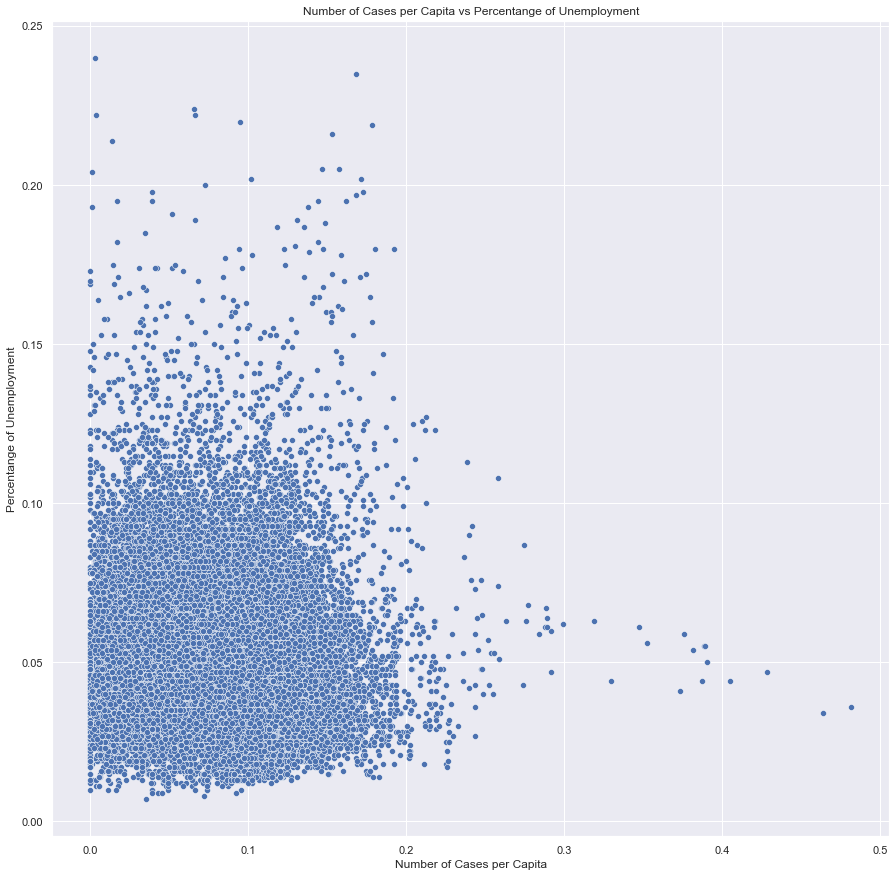

In [20]:
sns.set(rc = {'figure.figsize':(15,15)})
plt.xlabel('Number of Cases per Capita')
plt.ylabel('Percentange of Unemployment')
plt.title('Number of Cases per Capita vs Percentange of Unemployment')
sns.scatterplot(x=X['Cases'], y=y);


# As seen in the graph, the correlation between the Number of Cases and the Unemployment rate is very low

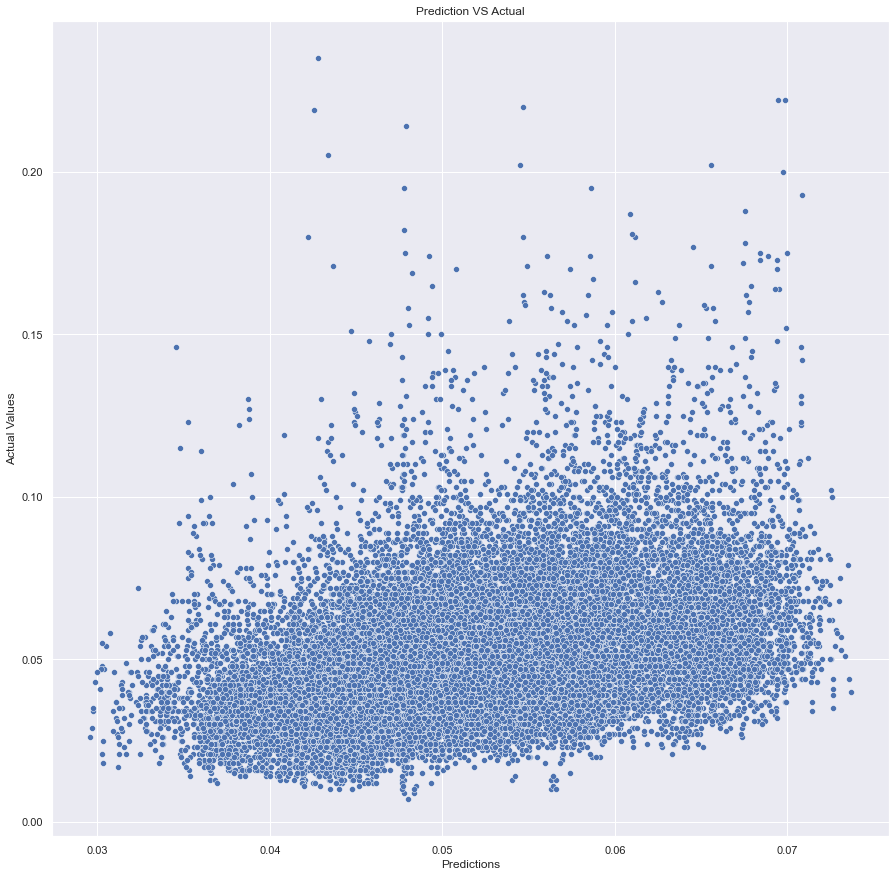

In [21]:
plt.xlabel('Predictions')
plt.ylabel('Actual Values')
plt.title('Prediction VS Actual')
sns.scatterplot(x=our_model6a.predict(X_train), y=y_train);

## Lets improve our model

In [22]:
unemployment_data2 = unemployment_rate.iloc[:45066,:]
unemployment_data2['Unemployed'] = unemployment_data2['Unemployed'].str.replace(',', '').astype(int)
unemployment_rates_data2 = pd.pivot(data=unemployment_data2, index='FIPS', columns='Period', values='Unemployed')
unemployment_rates_data2 = unemployment_rates_data2[['Sep-20', 'Oct-20', 'Nov-20', 'Dec-20', 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21', 'Aug-21']]
unemployment_rates_data2 = unemployment_rates_data2.reset_index()

model_data2 = unemployment_rates_data2.merge(county_data, on = 'FIPS')
model_data2 = model_data2[['FIPS', 'POPESTIMATE2020','Sep-20', 'Oct-20', 'Nov-20', 'Dec-20', 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21', 'Aug-21', '9/30/20', '10/31/20', '11/30/20', '12/31/20', '1/31/21', '2/28/21', '3/31/21', '4/30/21', '5/31/21', '6/30/21', '7/31/21', '8/31/21', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]


# Same thing as before where I merge the unemployment data with county_data, except now for the values we are using the number of people unemployed rather than the unemployment rate.
# I did this for a good reason as explain below

In [23]:
trial3 = model_data2[['Sep-20', 'Oct-20', 'Nov-20', 'Dec-20', 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21', 'Aug-21']].T
trial4 = model_data2[['9/30/20', '10/31/20', '11/30/20', '12/31/20', '1/31/21', '2/28/21', '3/31/21', '4/30/21', '5/31/21', '6/30/21', '7/31/21', '8/31/21']].T

percentages6a2 = []
for col in trial3.columns:
    percentages6a2+=list(trial3[col])
    
cases6a2 = []
for col in trial4.columns:
    cases6a2+=list(trial4[col])

FIPS6a2 = []
NEVER6a2 = []
RARELY6a2 = []
SOMETIMES6a2 = []
FREQUENTLY6a2 = []
ALWAYS6a2 = []
POPESTIMATE20206a2 = []
dates=[]
for i in range(len(model_data2['FIPS'])):
    dates.extend(['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug'])
    for j in range(12):
        FIPS6a2.append(model_data2['FIPS'][i])
        NEVER6a2.append(model_data2['NEVER'][i])
        RARELY6a2.append(model_data2['RARELY'][i])
        SOMETIMES6a2.append(model_data2['SOMETIMES'][i])
        FREQUENTLY6a2.append(model_data2['FREQUENTLY'][i])
        ALWAYS6a2.append(model_data2['ALWAYS'][i])
        POPESTIMATE20206a2.append(model_data2['POPESTIMATE2020'][i])

labor2 = pd.DataFrame({'FIPS': FIPS6a2, 'NEVER':NEVER6a2, 'RARELY':RARELY6a2, 'SOMETIMES':SOMETIMES6a2, 'FREQUENTLY':FREQUENTLY6a2, 'ALWAYS':ALWAYS6a2, 'Unemployed':percentages6a2, 'Cases':cases6a2, 'Month': dates, 'POPESTIMATE2020':POPESTIMATE20206a2})
labor2

# Same thing as before where I prepare the data to be used for the model by making only 9 larger columns (since we are combining by months). 1 for what we are trying to predict and 8 for the parameter.

,FIPS,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,Unemployed,Cases,Month,POPESTIMATE2020
0,01001,0.053,0.074,0.134,0.295,0.444,1392,1792,Sep,56145
1,01001,0.053,0.074,0.134,0.295,0.444,898,2168,Oct,56145
2,01001,0.053,0.074,0.134,0.295,0.444,819,2780,Nov,56145
3,01001,0.053,0.074,0.134,0.295,0.444,756,4190,Dec,56145
4,01001,0.053,0.074,0.134,0.295,0.444,852,5669,Jan,56145
...,...,...,...,...,...,...,...,...,...,...
37675,56045,0.142,0.129,0.148,0.207,0.374,155,650,Apr,6743
37676,56045,0.142,0.129,0.148,0.207,0.374,161,654,May,6743
37677,56045,0.142,0.129,0.148,0.207,0.374,151,657,Jun,6743
37678,56045,0.142,0.129,0.148,0.207,0.374,116,681,Jul,6743


In [24]:
X2=labor2[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS', 'Cases']]
X2['Cases Per Capita'] = X2['Cases'] / labor2['POPESTIMATE2020']
y2=labor2['Unemployed'] / labor2['POPESTIMATE2020']
X2 = X2[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS', 'Cases Per Capita']]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.33, random_state=42)

our_model6a2 = LinearRegression()
our_model6a2.fit(X_train2, y_train2)
our_model6a2.predict(X_train2)

error2 = compute_CV_error(our_model6a2, X_train2, y_train2)
corr2 = our_model6a2.score(X_train2, y_train2)
print("Our Training Accuracy: ", corr2)
print("Our Cross Validation Error: ", error2)


# Previously I used the unemployment rate as what I tried to predict, however I saw that the unemployment rate consisted of number of people unemplyed and number of people in the workforce. 
# Thus, the number of people in the workforce was another factor I hadn't accounted for since it also changed through time.
# So instead this time I decided to use the number of of unemployed people as it was. 
# Then I divided both the number of people unemployed and the number of cases by the county's total population.

Our Training Accuracy:  0.19758252040209312
Our Cross Validation Error:  0.007640439371202426


To try to improve the model, I decided to use the number of people unemployed in a county rather than the proportion of unemployed/work force. Having this data we decided to take the number of cases and number of unemployed and divide them by the total population. I kept everything else the same, however, the accuracy didn't increase as much as I had originally thought.

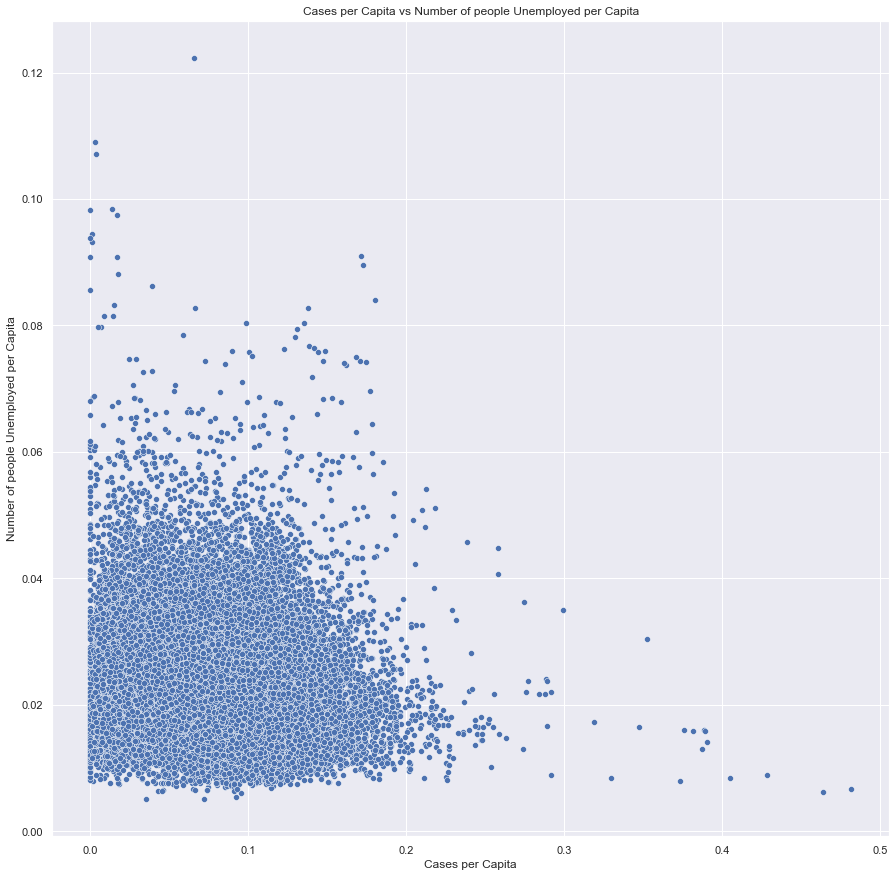

In [25]:
plt.xlabel('Cases per Capita')
plt.ylabel('Number of people Unemployed per Capita')
plt.title('Cases per Capita vs Number of people Unemployed per Capita')
sns.scatterplot(x=X2['Cases Per Capita'], y=y2);

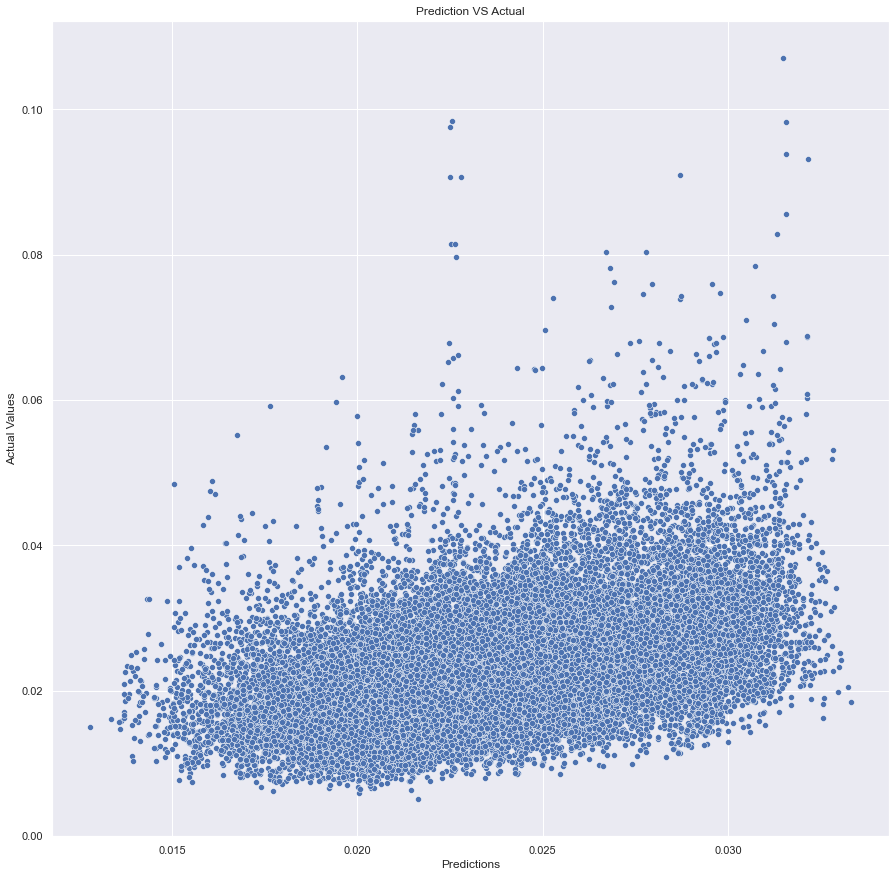

In [26]:
plt.xlabel('Predictions')
plt.ylabel('Actual Values')
plt.title('Prediction VS Actual')
sns.scatterplot(x=our_model6a2.predict(X_train2), y=y_train2);

## Improving Even Further!

In [27]:
X3=labor2[['Cases', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
y3=labor2['Unemployed']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.33, random_state=42)

our_model6a3 = LinearRegression()
our_model6a3.fit(X_train3, y_train3)
our_model6a3.predict(X_train3)

error3 = compute_CV_error(our_model6a3, X_train3, y_train3)
corr3 = our_model6a3.score(X_train3, y_train3)
print("Our Training Accuracy: ", corr3)
print("Our Cross Validation Error: ", error3)

Our Training Accuracy:  0.690368773561041
Our Cross Validation Error:  7535.1802799108045


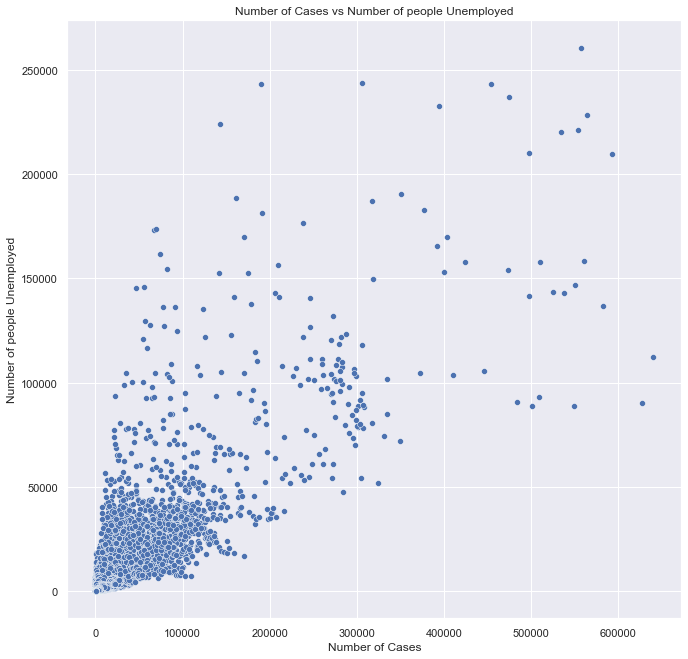

In [28]:
# Remove outliers
final_plotX = labor2[labor2['Unemployed']< 300000]['Cases']
final_ploty = labor2[labor2['Unemployed']< 300000]['Unemployed']

plt.figure(figsize=(11, 11))
sns.scatterplot(x=final_plotX, y=final_ploty)
plt.xlabel('Number of Cases')
plt.ylabel('Number of people Unemployed')
plt.title('Number of Cases vs Number of people Unemployed');

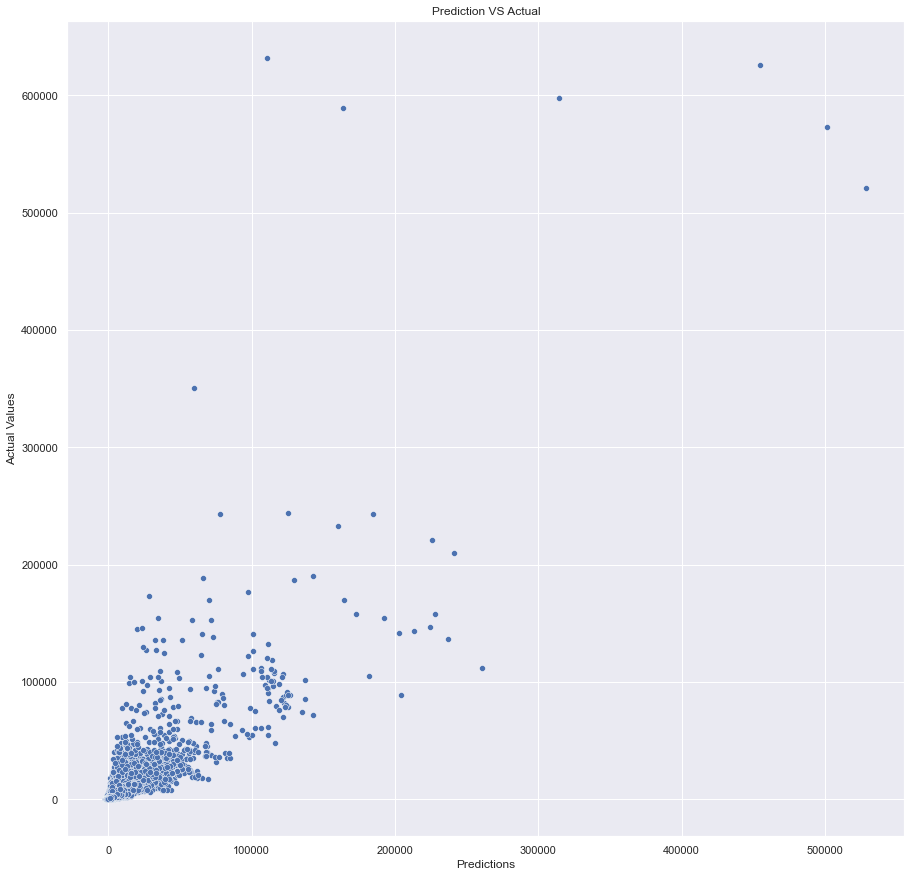

In [29]:
plt.xlabel('Predictions')
plt.ylabel('Actual Values')
plt.title('Prediction VS Actual')
sns.scatterplot(x=our_model6a3.predict(X_train3), y=y_train3);

Finally instead of to divide both the number of cases and the nuber of unemployed people by the total population in that county, I decided to just leave the number of cases and the nuber of unemployed people as they were and try to predict the nuber of unemployed people by the number of cases and the parameters for mask usage. As seen throught all graphs, the correlation between number of cases and number of unemployed seems much higher than the rest.

In [30]:
# Testing the final model on the test data

our_model6a3.predict(X_test3)

error3 = compute_CV_error(our_model6a3, X_test3, y_test3)
corr3 = our_model6a3.score(X_test3, y_test3)
print("Our Testing Accuracy: ", corr3)
print("Our Testing Cross Validation Error: ", error3)

Our Testing Accuracy:  0.7916915833144682
Our Testing Cross Validation Error:  7145.793624921139


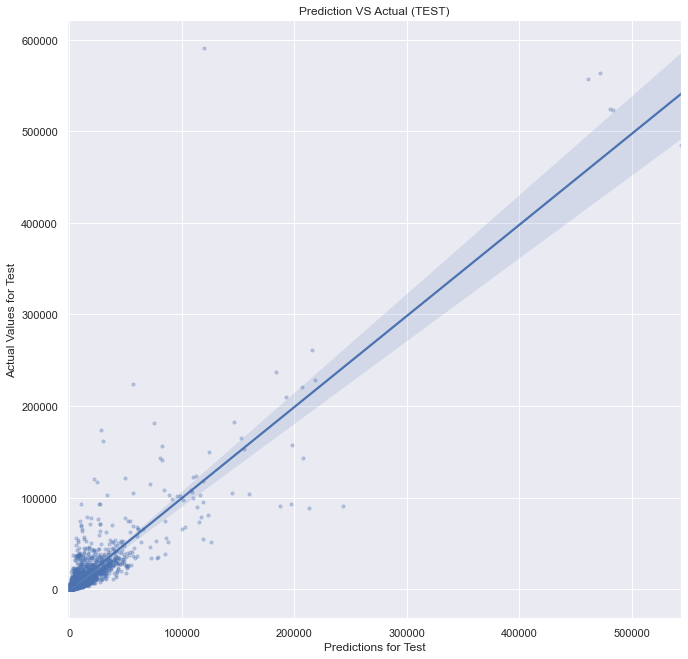

In [31]:
testDataFrame = pd.DataFrame({'actual':y_test3, 'prediction':our_model6a3.predict(X_test3)})
plt.figure(figsize=(11, 11))

# text
# Plotting the final model with test data.
# Below I removed some outliers to zoom in 

sns.regplot(data = testDataFrame, x='prediction', y='actual', scatter_kws={'s':10, "alpha":0.3})
plt.xlabel('Predictions for Test')
plt.ylabel('Actual Values for Test')
plt.title('Prediction VS Actual (TEST)');

In [32]:
list_of_coef = list(our_model6a3.coef_)
list_of_coef
# Equation f(x): predicting function
# f(x) = 0.3856157624872213*CASES + 163129.5268858097*NEVER + 162064.19088911277*RARELY + 160995.8475563524*SOMETIMES + 160194.6650264655*FREQUENTLY + 166360.547540274*ALWAYS

[0.3856157624872213,
 163129.5268858097,
 162064.19088911277,
 160995.8475563524,
 160194.6650264655,
 166360.547540274]

**CASES**: referes to the number of cases in a county 

**Never**: referes to the percentage of people who never use masks in a county

**RARELY**: referes to the percentage of people who RARELY use masks in a county

**SOMETIMES**: referes to the percentage of people who SOMETIMES use masks in a county

**FREQUENTLY**: referes to the percentage of people who FREQUENTLY use masks in a county

**ALWAYS**: referes to the percentage of people who ALWAYS use masks in a county

**f(x)**: referes to the number of people unemployed in a county

In evaluating the model, it's calculated that the R^2 value for our predicted unemployment numbers in the test data vs. the actual unemployment numbers in the test data was 0.792. This shows that unemployment numbers across counties are highly correlated with case numbers and masking rates across counties. It is appropriate to look at the R^2 value when evaluating our model because we want to understand how close the data is to our fitted regression line.

# Now lets start with A/B Testing

In [33]:
# uploading unemployment data before covid (2018)
# data can be found under 'county data' in: https://www.bls.gov/lau/

# header_list = ['LAUS Code','state code','county code','County Name/State Abbreviation','Period', 'nan','Force','Employed','Unemployed','(%)']
# file_2018 = pd.read_csv('data/laucnty18.csv', dtype = {'state code':'str', 'county code':'str'}).reset_index()
# file_2018.to_csv('data/laucnty18.csv', header=header_list, index=False)

unemployment_rate_2018 = pd.read_csv('data/laucnty18.csv').iloc[1:,:]
unemployment_rate_2018['FIPS'] = unemployment_rate_2018['state code'] + unemployment_rate_2018['county code']
unemployment_rate_2018 = unemployment_rate_2018[['County Name/State Abbreviation', 'Period', 'Force', 'Employed', 'Unemployed', '(%)', 'FIPS']]
unemployment_rate_2018


,County Name/State Abbreviation,Period,Force,Employed,Unemployed,(%),FIPS
1,"Autauga County, AL",2018,"26,475","25,524",951,3.6,01001
2,"Baldwin County, AL",2018,"96,252","92,769","3,483",3.6,01003
3,"Barbour County, AL",2018,"8,505","8,071",434,5.1,01005
4,"Bibb County, AL",2018,"8,698","8,354",344,4.0,01007
5,"Blount County, AL",2018,"25,337","24,454",883,3.5,01009
...,...,...,...,...,...,...,...
3215,"Vega Baja Municipio, PR",2018,"13,159","11,787","1,372",10.4,72145
3216,"Vieques Municipio, PR",2018,"2,726","2,276",450,16.5,72147
3217,"Villalba Municipio, PR",2018,"7,335","6,174","1,161",15.8,72149
3218,"Yabucoa Municipio, PR",2018,"8,791","7,534","1,257",14.3,72151


In [34]:
# uploading unemployment data before covid (2020)
# data can be found under 'county data' in: https://www.bls.gov/lau/

# header_list = ['LAUS Code','state code','county code','County Name/State Abbreviation','Period', 'nan','Force','Employed','Unemployed','(%)']
# file_2020 = pd.read_csv('data/laucnty20.csv', dtype = {'state code':'str', 'county code':'str'}).reset_index()
# file_2020.to_csv('data/laucnty20.csv', header=header_list, index=False)

unemployment_rate_2020 = pd.read_csv('data/laucnty20.csv').iloc[1:,:]
unemployment_rate_2020['FIPS'] = unemployment_rate_2020['state code'] + unemployment_rate_2020['county code']
unemployment_rate_2020 = unemployment_rate_2020[['County Name/State Abbreviation', 'Period', 'Force', 'Employed', 'Unemployed', '(%)', 'FIPS']]
unemployment_rate_2020


,County Name/State Abbreviation,Period,Force,Employed,Unemployed,(%),FIPS
1,"Autauga County, AL",2020,"26,405","24,985","1,420",5.4,01001
2,"Baldwin County, AL",2020,"98,910","92,751","6,159",6.2,01003
3,"Barbour County, AL",2020,"8,680","8,004",676,7.8,01005
4,"Bibb County, AL",2020,"8,712","8,073",639,7.3,01007
5,"Blount County, AL",2020,"25,116","23,973","1,143",4.6,01009
...,...,...,...,...,...,...,...
3216,"Vega Baja Municipio, PR",2020,N.A.,N.A.,N.A.,N.A.,72145
3217,"Vieques Municipio, PR",2020,N.A.,N.A.,N.A.,N.A.,72147
3218,"Villalba Municipio, PR",2020,N.A.,N.A.,N.A.,N.A.,72149
3219,"Yabucoa Municipio, PR",2020,N.A.,N.A.,N.A.,N.A.,72151


### We now have our data for both 2018 (pre covid) and 2020 (post covid)

Now lets do some data cleaning!

In [35]:
unemployment_rate_2018.isna().sum()

County Name/State Abbreviation    0
Period                            0
Force                             0
Employed                          0
Unemployed                        0
(%)                               0
FIPS                              0
dtype: int64

In [36]:
unemployment_rate_2020.replace({'N.A.':np.float('nan')}).isna().sum()

County Name/State Abbreviation     0
Period                             0
Force                             78
Employed                          78
Unemployed                        78
(%)                               78
FIPS                               0
dtype: int64

In [37]:
unemployment_rate_2020 = unemployment_rate_2020.replace({'N.A.':np.float('nan')}).dropna()
county_list_available = unemployment_rate_2020['FIPS']
unemployment_rate_2018 = unemployment_rate_2018[unemployment_rate_2018['FIPS'].isin(county_list_available)]

unemployment_rate_2018 = unemployment_rate_2018.reset_index().drop('index', axis=1)
unemployment_rate_2020 = unemployment_rate_2020.reset_index().drop('index', axis=1)

In [38]:
unemployment_rate_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   County Name/State Abbreviation  3140 non-null   object
 1   Period                          3140 non-null   object
 2   Force                           3140 non-null   object
 3   Employed                        3140 non-null   object
 4   Unemployed                      3140 non-null   object
 5   (%)                             3140 non-null   object
 6   FIPS                            3140 non-null   object
dtypes: object(7)
memory usage: 171.8+ KB


In [39]:
unemployment_rate_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   County Name/State Abbreviation  3142 non-null   object
 1   Period                          3142 non-null   object
 2   Force                           3142 non-null   object
 3   Employed                        3142 non-null   object
 4   Unemployed                      3142 non-null   object
 5   (%)                             3142 non-null   object
 6   FIPS                            3142 non-null   object
dtypes: object(7)
memory usage: 172.0+ KB


In [40]:
np.setdiff1d(unemployment_rate_2020['FIPS'], unemployment_rate_2018['FIPS'])
# finds the set difference in two arrays

array(['02063', '02066'], dtype=object)

In [41]:
unemployment_rate_2020[unemployment_rate_2020['FIPS'].isin(['02063', '02066'])]

,County Name/State Abbreviation,Period,Force,Employed,Unemployed,(%),FIPS
72,"Chugach Census Area, AK",2020,"3,251","2,972",279,8.6,02063
73,"Copper River Census Area, AK",2020,"1,290","1,153",137,10.6,02066


In [42]:
unemployment_rate_2018 = unemployment_rate_2018.astype({'(%)':float})
unemployment_rate_2020 = unemployment_rate_2020.astype({'(%)':float})

## Now let's start with the A/B testing process

Lets start by making one dataset with all rows from both datasets in order to shuffle the labels

In [43]:
unemployment_rate_AB = unemployment_rate_2018.append(unemployment_rate_2020).reset_index().drop('index', axis=1)
unemployment_rate_AB


,County Name/State Abbreviation,Period,Force,Employed,Unemployed,(%),FIPS
0,"Autauga County, AL",2018,"26,475","25,524",951,3.6,01001
1,"Baldwin County, AL",2018,"96,252","92,769","3,483",3.6,01003
2,"Barbour County, AL",2018,"8,505","8,071",434,5.1,01005
3,"Bibb County, AL",2018,"8,698","8,354",344,4.0,01007
4,"Blount County, AL",2018,"25,337","24,454",883,3.5,01009
...,...,...,...,...,...,...,...
6277,"Sweetwater County, WY",2020,"20,503","18,998","1,505",7.3,56037
6278,"Teton County, WY",2020,"15,138","14,251",887,5.9,56039
6279,"Uinta County, WY",2020,"9,102","8,532",570,6.3,56041
6280,"Washakie County, WY",2020,"3,945","3,739",206,5.2,56043


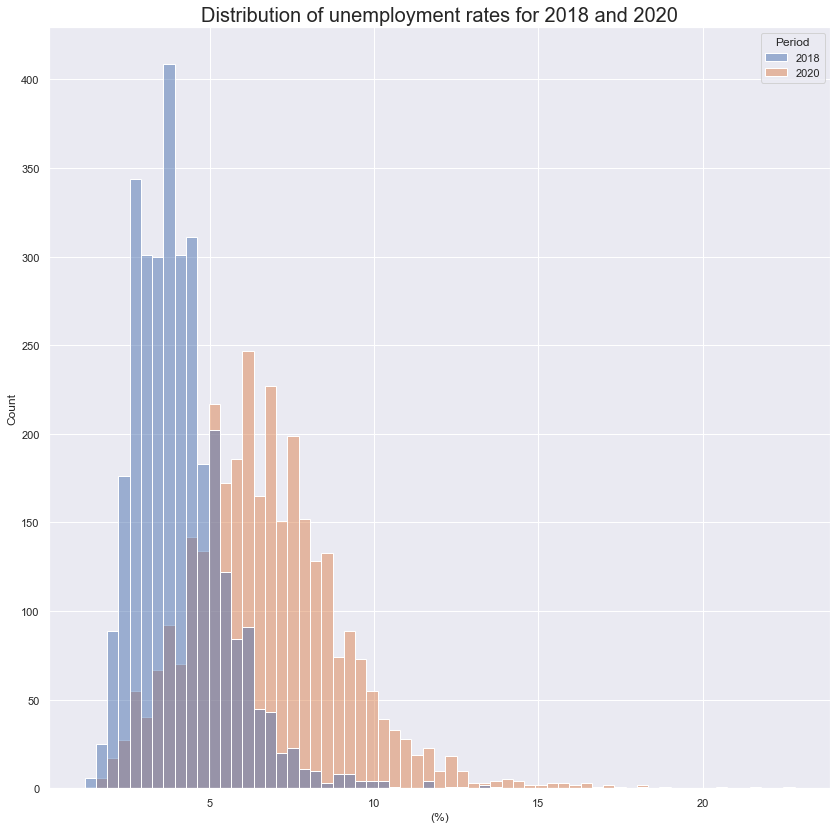

In [44]:
sns.set(rc = {'figure.figsize':(14,14)})
plt.title('Distribution of unemployment rates for 2018 and 2020', fontdict={'fontsize':20})
sns.histplot(data=unemployment_rate_AB, x='(%)', hue='Period');


### Let's review our hypothesis:

2020: Unemploment numbers in counties during covid

2018: Unemploment numbers in counties before covid

Null: The distribution in Unemployment numbers in counties are the same during and before covid

Alternative: In the counties, the unemployment numbers during covid were more, on average, than the unemployment numbers before covid

Our Test Statistic: difference between our group means (used to give evidence towards the alternative hypothesis)
                    
                    (mean(2018_unemployment_percentage) - mean(2020_unemployment_percentage))
                    
- This way negative numbers show higher unemployment rates in 2020 and poitive numbers show higher unemployment rates in 2018

- We will have a p-value cuttoff of 1%

In [45]:
# Simulating the test statistic under the null hypothesis (by shuffling the year labels)
test_statistics_array = []
for i in range(10000):
    sampled_period = unemployment_rate_AB['Period'].sample(frac=1, replace=False).reset_index().drop('index', axis=1)
    AB_df = unemployment_rate_AB.drop('Period', axis=1)
    AB_df['Period'] = sampled_period
    
    statistic = np.mean(AB_df[AB_df['Period']=='2018']['(%)']) - np.mean(AB_df[AB_df['Period']=='2020']['(%)'])
    test_statistics_array.append(statistic)

In [46]:
observed_test_statistic = np.mean(unemployment_rate_AB[unemployment_rate_AB['Period']=='2018']['(%)']) - np.mean(unemployment_rate_AB[unemployment_rate_AB['Period']=='2020']['(%)'])
print("Our observed test statistic: ", observed_test_statistic)


Our observed test statistic:  -2.645892550892558


In [54]:
# Finding simulated value corresponding to 1% of 10000 = 100
p_value_cuttoff = np.sort(np.array(test_statistics_array)).item(100)
print("one percent cuttoff at: ",p_value_cuttoff)

one percent cuttoff at:  -0.13860162499441842


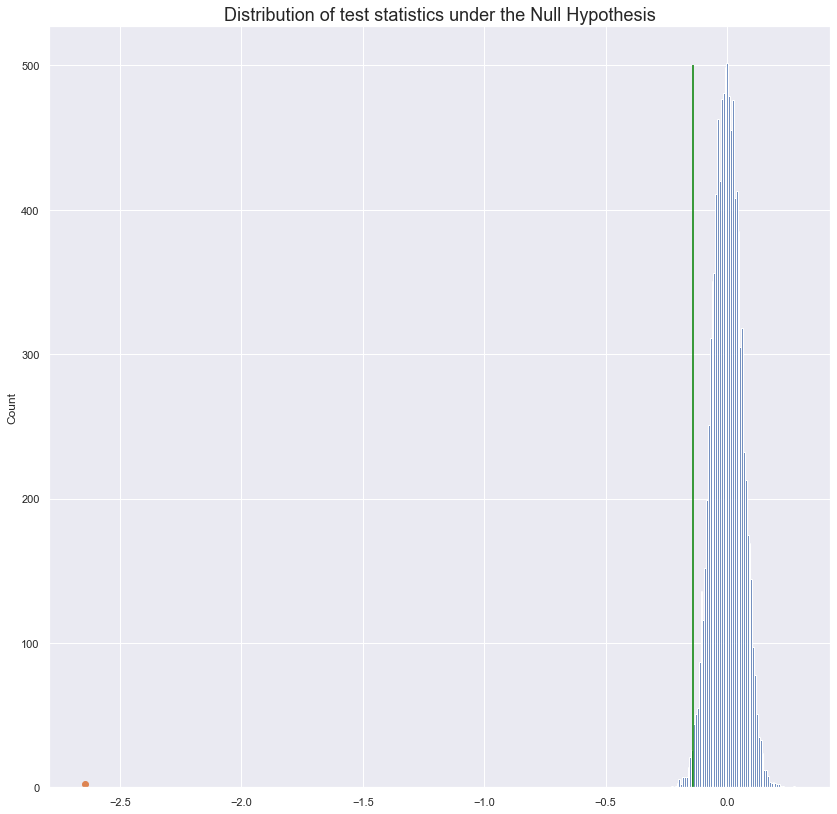

In [60]:
sns.histplot(test_statistics_array, bins='auto')
plt.title('Distribution of test statistics under the Null Hypothesis', fontdict={'fontsize':18})
plt.scatter(observed_test_statistic, 2)
plt.vlines(p_value_cuttoff, 0, 500, color='green');

Inconsistent with the null! 

Our observed statistic is farther left (to the direction of the Alternative Hypothesis) than the tail of the distribution of the test statistics under the Null Hypothesis.

P-value = 0

P-value cuttoff = 0.01

Thus, our observed statistic is inconsistent with the null and our test favors the Alternative!